In [1]:
import sys
sys.path.append('../gtm/')
sys.path.append('../simulation/')
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import linear_sum_assignment
from random import random
import torch
import pandas as pd
from tqdm import tqdm
from corpus import GTMCorpus
from gtm import GTM
from simulations import generate_docs_by_lda

/home/germain/Documents/topic models/generalized_topic_model/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/germain/Documents/topic models/generalized_topic_model/venv/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/germain/Documents/topic models/generalized_topic_model/venv/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'num

In [2]:
cossim_list = []
true_doc_topic_list = []
estimated_doc_topic_list = []

doc_topic_prior = 'logistic_normal'
update_prior = True
num_epochs = 100
num_iter = 1
num_jobs = 4
num_topics = 3
num_covs = 1
num_docs = 50000
min_words = 200
max_words = 300
voc_size = 100

np.random.seed(42)
lambda_ = np.array(
    [[ 0,0.5,0.3],
    [ 0,-0.5,-0.4]])
sqrt_sigma = np.random.rand(num_topics, num_topics)
sigma = sqrt_sigma * sqrt_sigma.T

dict_betas = {}
for i in range(num_topics):
    dict_betas[i] = {}
    for c in range(num_covs+1):
        dict_betas[i][c] = []

for i in range(num_iter):
    
    print(i)
    
    gtm_model_args = {
        "n_topics": num_topics,
        "num_epochs":num_epochs,
        "update_prior": update_prior,
        "doc_topic_prior": doc_topic_prior,
        "seed":42,
        "tol":0.000000000000000000001
        }
    
    df_true_dist_list_gtm, df_test = generate_docs_by_lda(
        num_docs, 
        num_topics, 
        num_covs, 
        doc_topic_prior, 
        lambda_, 
        sigma,
        min_words, 
        max_words, 
        voc_size, 
        num_jobs,
        seed=i
    )  
    
    test_dataset = GTMCorpus(
        df_test,
        prevalence = "~ cov_0 + cov_1 - 1"
    )
    tm_test = GTM(
        train_data = test_dataset,
        **gtm_model_args
    )
    df_doc_topic_gtm = pd.DataFrame(
            tm_test.get_doc_topic_distribution(test_dataset),
            index=["Doc{}".format(i) for i in range(num_docs)],
            columns=["Topic{}".format(i) for i in range(num_topics)],
        )
    true_df = df_true_dist_list_gtm[0]
    estimated_df = df_doc_topic_gtm

    ### matching the columns of estimated doc_topic dist with those of true doc_topic dist by maximizing dot-product
    score_list = []
    for true_col in true_df.columns:
        true_target_col = true_df.loc[:, true_col]
        score_list_per_row = []
        for col in estimated_df.columns:
            target_col = estimated_df.loc[:, col]
            score_list_per_row.append(np.dot(target_col, true_target_col))
        score_list.append(score_list_per_row)
    corres_num_topic_dict_gtm = {}
    corres_num_topic_dict_gtm_bis = {}
    score_matrix = pd.DataFrame(score_list)
    true_topics, estimated_topics = linear_sum_assignment(-score_matrix)
    for true_topic, estimated_topic in zip(true_topics, estimated_topics):
        corres_num_topic_dict_gtm["Topic{}".format(true_topic)] = "Topic{}".format(
            estimated_topic
        )
        corres_num_topic_dict_gtm_bis[true_topic] = estimated_topic
    reanged_df_gtm = estimated_df.loc[:, corres_num_topic_dict_gtm.values()]
    reanged_df_gtm.columns = corres_num_topic_dict_gtm.keys()

    true_doc_topic_list.append(true_df)
    estimated_doc_topic_list.append(reanged_df_gtm)

    lambda_hat = tm_test.prior.lambda_
    lambda_hat = lambda_hat - lambda_hat[:, corres_num_topic_dict_gtm_bis[0]][:, None]

    for i in range(num_topics):
        for c in range(num_covs+1):
            dict_betas[i][c] = dict_betas[i][c] + [lambda_hat[c, corres_num_topic_dict_gtm_bis[i]]]    

    ### calculating the cossim scores between true and estimated doc_topic dist
    cossim_score_gtm = []
    for col in true_df.columns:
        inner_res = []
        series_1 = true_df.loc[:, col]
        series_2 = reanged_df_gtm.loc[:, col]
        cossim_score_gtm.append(
            np.dot(series_1.T, series_2)
            / (np.linalg.norm(series_1) * np.linalg.norm(series_2)))
    cossim_list.append(cossim_score_gtm)
    print("finished {} topics' simulation".format(num_topics))
    print()

/home/germain/Documents/topic models/generalized_topic_model/notebooks/../simulation/simulations.py:68: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  sample = np.random.multivariate_normal(mean, sigma)


0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:00<00:00, 55.31it/s]



Epoch   1	Mean Training Loss:1337.5316240

Topic_0: ['word_98', 'word_82', 'word_38', 'word_79', 'word_49', 'word_22', 'word_74', 'word_59']
Topic_1: ['word_16', 'word_91', 'word_97', 'word_53', 'word_28', 'word_79', 'word_48', 'word_62']
Topic_2: ['word_9', 'word_88', 'word_39', 'word_82', 'word_38', 'word_84', 'word_30', 'word_18']



Epoch   2	Mean Training Loss:1140.1306351

Topic_0: ['word_98', 'word_49', 'word_82', 'word_38', 'word_79', 'word_22', 'word_42', 'word_74']
Topic_1: ['word_16', 'word_53', 'word_91', 'word_79', 'word_15', 'word_33', 'word_42', 'word_47']
Topic_2: ['word_9', 'word_82', 'word_30', 'word_84', 'word_38', 'word_39', 'word_88', 'word_16']



Epoch   3	Mean Training Loss:1129.1989124

Topic_0: ['word_98', 'word_49', 'word_38', 'word_79', 'word_82', 'word_42', 'word_34', 'word_53']
Topic_1: ['word_16', 'word_53', 'word_15', 'word_79', 'word_47', 'word_42', 'word_91', 'word_33']
Topic_2: ['word_9', 'word_30', 'word_84', 'word_82', 'word_38', 'word_16', 'word_8

In [3]:
lambda_

array([[ 0. ,  0.5,  0.3],
       [ 0. , -0.5, -0.4]])

In [4]:
lambda_hat

tensor([[-0.3930,  0.0000,  0.6356],
        [-0.0196,  0.0000, -0.0451]], device='cuda:0')

/home/germain/Documents/topic models/generalized_topic_model/venv/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/home/germain/Documents/topic models/generalized_topic_model/venv/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


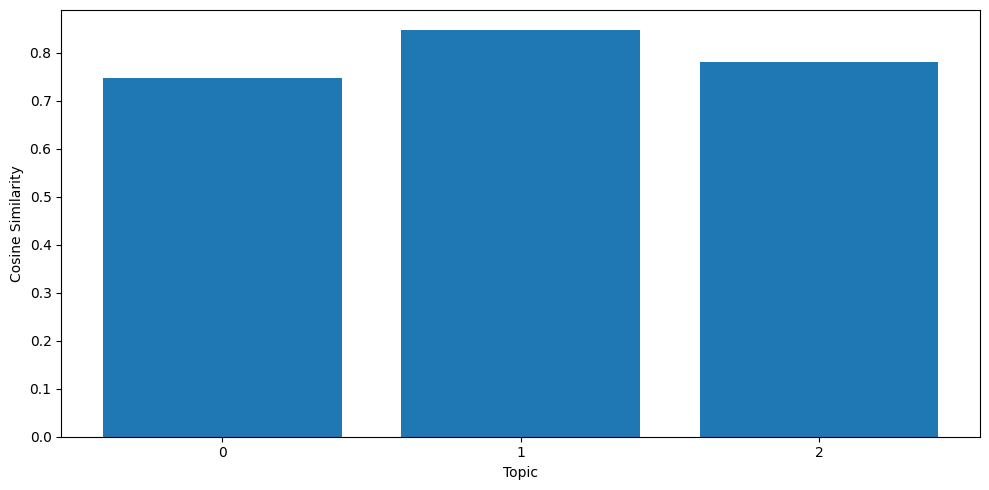

In [5]:
fig = plt.figure(figsize=(10,5),facecolor="white", tight_layout=True)
ax = fig.add_subplot(1, 1, 1,xlabel="Topic", ylabel="Cosine Similarity")
df_score_res = pd.DataFrame(cossim_list,index=["Iter_{}".format(i) for i in range(num_iter)])
x = np.array(range(num_topics))
ax.set_xticks(x)
mean = df_score_res.mean(axis=0)
std = df_score_res.std(axis=0)
ax.bar(x, mean, yerr=std)
plt.savefig('doc_topic_proportions.png')

In [6]:
for i in range(num_topics):
    for c in range(num_covs+1):
#        data = dict_betas[i][c]
        data = [i.cpu().numpy() for i in dict_betas[i][c]]
        true_value = lambda_[c,i]
        mean = np.mean(data)
        se = np.std(data)
        print("Topic {} | Cov {}".format(i,c+1))
        print("True Value: {} | Mean: {} | SE: {}".format(
            true_value,
            mean,
            se))
        print('\n')

Topic 0 | Cov 1
True Value: 0.0 | Mean: 0.0 | SE: 0.0


Topic 0 | Cov 2
True Value: 0.0 | Mean: 0.0 | SE: 0.0


Topic 1 | Cov 1
True Value: 0.5 | Mean: 0.6355737447738647 | SE: 0.0


Topic 1 | Cov 2
True Value: -0.5 | Mean: -0.0450863391160965 | SE: 0.0


Topic 2 | Cov 1
True Value: 0.3 | Mean: -0.3930400311946869 | SE: 0.0


Topic 2 | Cov 2
True Value: -0.4 | Mean: -0.01963922381401062 | SE: 0.0




In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(num_topics-1, num_covs + 1, figsize=(15, 10))

for i in range(1,num_topics):
    for c in range(num_covs + 1):
#        data = dict_betas[i][c]
        data = [i.cpu().numpy() for i in dict_betas[i][c]]
        mean = np.mean(data)
        se = np.std(data)
        ax = axes[i-1, c]
        ax.hist(data, bins=30, alpha=1, color='lightblue', label='Mean = {:.2f}, SE = {:.2f}'.format(mean,se))
        vertical_line_value = round(lambda_[c, i], 2)  
        ax.axvline(x=vertical_line_value, color='black', linestyle='dashed', linewidth=1,
                   label='True Value = {}'.format(vertical_line_value))
        ax.set_xlabel('Estimates')
        ax.set_ylabel('Frequency')
        ax.legend()

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig('monte_carlos_barplots.png')

ValueError: `dataset` input should have multiple elements.

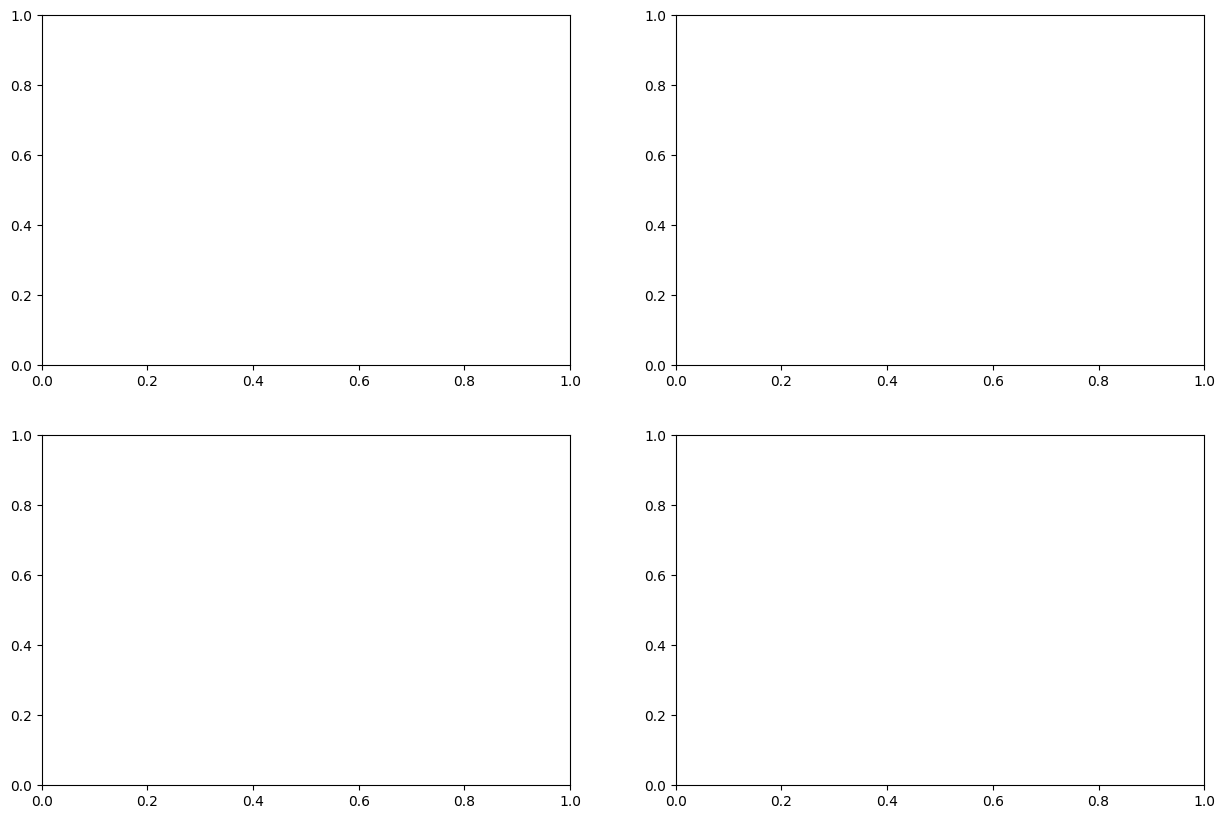

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

fig, axes = plt.subplots(num_topics-1, num_covs + 1, figsize=(15, 10))

for i in range(1,num_topics):
    for c in range(num_covs + 1):
#        data = dict_betas[i][c]
        data = [i.cpu().numpy() for i in dict_betas[i][c]]
        mean = np.mean(data)
        se = np.std(data)
        kde = gaussian_kde(data)
        x = np.linspace(min(data) - 1, max(data) + 1, 1000)
        ax = axes[i-1, c]
        ax.fill_between(x, kde(x), alpha=1, color='lightblue', label='Mean = {:.2f}, SE = {:.2f}'.format(mean,se))
        vertical_line_value = round(lambda_[c, i], 2)  
        ax.axvline(x=vertical_line_value, color='black', linestyle='dashed', linewidth=1,
                   label='True Value = {}'.format(vertical_line_value))
        ax.set_xlabel('Estimates')
        ax.set_ylabel('Density')
        ax.legend()

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig('monte_carlos_kde_plots.png')